<a href="https://colab.research.google.com/github/Harsh06-7/Customer-segmentation-using-clustering/blob/main/week2_customer%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

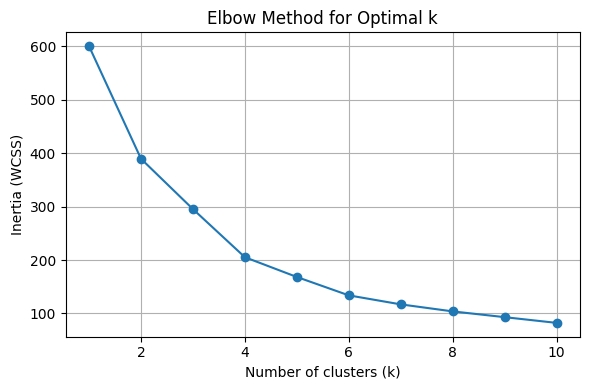

Silhouette scores:
k=2, silhouette=0.335
k=3, silhouette=0.358
k=4, silhouette=0.404
k=5, silhouette=0.417
k=6, silhouette=0.428
k=7, silhouette=0.417
k=8, silhouette=0.408
k=9, silhouette=0.418
k=10, silhouette=0.407


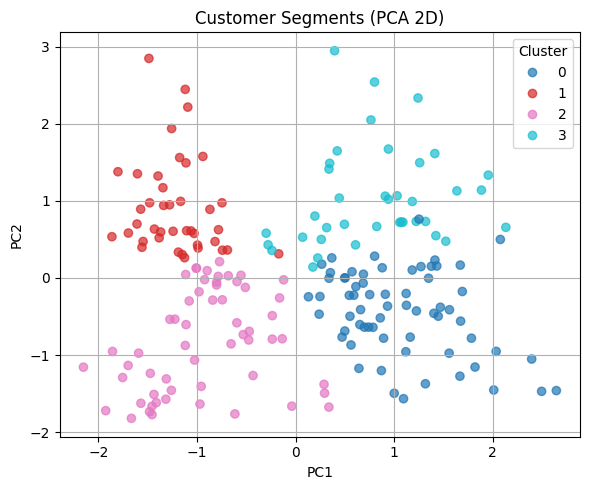

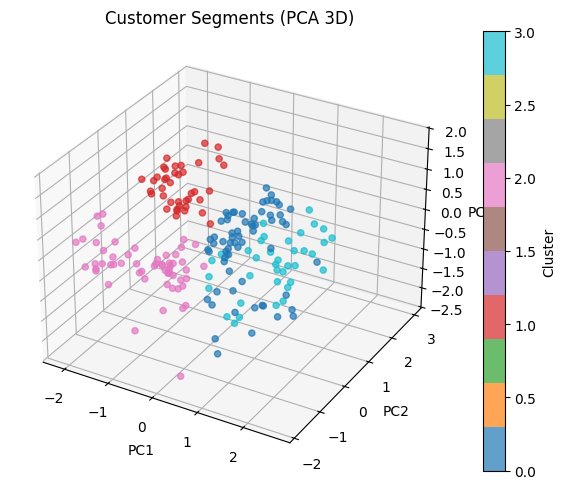


Cluster profile (feature means):
               Age  Annual Income (k$)  Spending Score (1-100)
cluster                                                       
0        53.984615           47.707692               39.969231
1        32.875000           86.100000               81.525000
2        25.438596           40.000000               60.298246
3        39.368421           86.500000               19.578947

Segmentation complete. Files saved:
  - customers_with_clusters.csv
  - cluster_profile_summary.csv


In [ ]:
# ============================
# CUSTOMER SEGMENTATION PROJECT
# K-Means + Elbow + PCA (2D/3D)
# Tech stack: Python, Pandas, Scikit-learn, Matplotlib
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ========= 1. LOAD DATA =========
df = pd.read_csv("Mall_Customers.csv")

# Example: pick numeric behavior features (edit to your columns)
features = [
    "Age",
    "Annual Income (k$)",
    "Spending Score (1-100)",
]

X = df[features].copy()

# ========= 2. CLEANING & SCALING =========
# Handle missing values (simple median imputation)
X = X.fillna(X.median())

# Optional: log-transform highly skewed monetary columns
# X["monetary_value"] = np.log1p(X["monetary_value"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========= 3. ELBOW METHOD (INERTIA) =========
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        random_state=42
    )
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========= 4. SILHOUETTE SCORES (OPTIONAL) =========
print("Silhouette scores:")
for k in range(2, 11):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        random_state=42
    )
    labels_k = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_k)
    print(f"k={k}, silhouette={sil:.3f}")

# ========= 5. FINAL K-MEANS MODEL =========
# Set this after checking elbow & silhouette
best_k = 4  # <-- change based on your plots

kmeans_final = KMeans(
    n_clusters=best_k,
    init="k-means++",
    n_init=10,
    random_state=42
)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df["cluster"] = cluster_labels

# ========= 6. OPTIONAL: HIERARCHICAL CLUSTERING =========
# For small datasets, you can compare with Agglomerative
use_hierarchical = False  # set True if you want to run this

if use_hierarchical:
    agg = AgglomerativeClustering(
        n_clusters=best_k,
        affinity="euclidean",
        linkage="ward"
    )
    h_labels = agg.fit_predict(X_scaled)
    df["cluster_h"] = h_labels

# ========= 7. PCA FOR 2D VISUALIZATION =========
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=cluster_labels,
    cmap="tab10",
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Customer Segments (PCA 2D)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========= 8. PCA FOR 3D VISUALIZATION =========
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")
p3 = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=cluster_labels,
    cmap="tab10",
    alpha=0.7
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
fig.colorbar(p3, ax=ax, label="Cluster")
plt.title("Customer Segments (PCA 3D)")
plt.tight_layout()
plt.show()

# ========= 9. CLUSTER PROFILING =========
cluster_profile = df.groupby("cluster")[features].mean()
print("\nCluster profile (feature means):")
print(cluster_profile)

# Save cluster assignments and profile
df.to_csv("customers_with_clusters.csv", index=False)
cluster_profile.to_csv("cluster_profile_summary.csv")

print("\nSegmentation complete. Files saved:")
print("  - customers_with_clusters.csv")
print("  - cluster_profile_summary.csv")
